<a name="title"></a>
***
<h1 style="color:#00004D">Coursera's Next Strategic Plan: Capitalizing Frequent Itemset Mining to Improve Recommender Systems</h1>

***

<center><img src="title.png"/></center>

<a name="subtitle"></a>
***
<h2 style="color:#00004D">Code Display</h2>

***

In [1]:
from IPython.display import HTML
HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

<a name="subtitle"></a>
***
<h2 style="color:#00004D">Import Libraries and Global Variables Settings</h2>

***

In [70]:
import dmw2_lr2
import gzip
import sqlite3
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import time
import datetime as dt
import folium
import warnings
import psycopg2
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from collections import defaultdict
from scipy import stats

from tqdm import tqdm

from sklearn.base import TransformerMixin
from sklearn.base import clone

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

# set global plotting parameters
custom_sns_params = {'figure.figsize':(12, 8), 'axes.spines.right': False, 
                     'axes.spines.top': False}
sns.set_theme('notebook', style='ticks', rc=custom_sns_params)
colors = ["#1d3557", "#f1faee"]
custom_palette = sns.blend_palette(colors, n_colors=5)
sns.set_palette(custom_palette)

# !pip install vaderSentiment
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import nltk  
# nltk.download('stopwords') 
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from collections import Counter
import cufflinks as cf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [71]:
# this is to return the post-processed datasets for exploratory data analysis

courses = '/mnt/data/public/coursera-reviews/Coursera_courses.csv'
reviews = '/mnt/data/public/coursera-reviews/Coursera_reviews.csv'

# SQLite db parameters
db = 'dmw2_labreport2.db'
tbl_coursedb = 'coursedb_202203'

# Collate datasets needed in an SQLite database
dmw2_lr2.prepare_data(courses, reviews, db, tbl_coursedb)

# Read tables needed from the SQLite database for analysis
conn = f'sqlite:///{db}'
df_coursedb = pd.read_sql(f"""SELECT * FROM {tbl_coursedb}""", conn)

reading the datasets needed...
writing data into an SQLite database...
data prepared and ready for analysis.


<a name="subtitle"></a>
***
<h2 style="color:#00004D">Lab 2 Technical Report</h2>

***

<a name="exec_summary"></a>
***
<h1 style="color:#0056D2">EXECUTIVE SUMMARY</h1>

***

Coursera is a platform that enables a global ecosystem of educators, learners, organizations, and institutions. As of December 31, 2022, approximately 118 million learners had registered on Coursera to learn from more than 300 leading university and industry partners. Coursera serves learners in their homes, through their employers, through their colleges and universities, and through government-sponsored programs [1]. 

The Company's mission is **"*to provide universal acces to world-class learning so that anyone, anywhere has the power to transform their life through learning.*"**

Teaching and learning in the digital age combine traditional and modern approaches which made learning more dynamic. Triggered further by the pandemic, online learning and virtual enrollment massively increased compared to its pre-pandemic level.

<img src='coursera_ecosystem.png' height='400'>

<center><b>Figure 1:</b> Global Learning Ecosystem </center>

Given this evident shift in exploring online learning as an alternative to the traditional means of studying, how can we then increase the course provider’s profitability by recommending similar courses to enrollees based on their preference/ courses enrolled to? 

We intend to build a system that recommends courses to virtual learners based on their previous enrolled courses and the association rules between the courses in the dataset. This way, we can leverage the association rules generated by the FIM step to identify courses that are frequently enrolled together and use this information to recommend related courses to enrollees based on their enrollment history. This approach is more focused on item-to-item relationships and does not require a collaborative filtering approach, making it less computationally expensive.

The course and review datasets of the Coursera-Reviews were merged, pre-processed, and collated into an SQLite database. From the merged datasets, we performed exploratory data analysis to derive additional insights. Based on the analysis, it was found that the use of a content-based recommender system utilizing frequent itemsets can provide a viable alternative to collaborative filtering in recommending Coursera courses. This method was found to be computationally efficient and can provide personalized recommendations based on a user's past course preferences and relevant course attributes. Additionally, the use of pre-processing techniques such as text cleaning and feature engineering can improve the accuracy and relevance of the recommendations. Overall, this approach can be a valuable tool for both Coursera users looking for personalized course recommendations and Coursera itself in terms of improving user engagement and satisfaction.

[ref]: #top
[Back to Table of Contents][ref]

<a name="top"></a>
***
<h1 style="color:#0056D2">TABLE OF CONTENTS</h1>

***

[ref0]: #exec_summary 
- [Executive Summary][ref0]
[ref1]: #prob_statement 
- [Problem Statement][ref1]
[ref2]: #motivation 
- [Motivation][ref2]
[ref3]: #list 
- [List of Tables and Figures][ref3]
[ref4]: #methodology 
- [Methodology][ref4]
[ref5]: #source 
- [Data Source and Description][ref5]
[ref6]: #exploration
- [Data Exploration][ref6]
[ref8]: #results
- [Results][ref8]
[ref9]: #conclusion
- [Conclusion][ref9]
[ref10]: #recommendation
- [Recommendations][ref10]
[ref11]: #references
- [References][ref11]

<a name="prob_statement"></a>
***
<h1 style="color:#0056D2">PROBLEM STATEMENT</h1>

***

Given this evident shift in exploring online learning as an alternative to the traditional means of studying, how can we then increase the course provider’s profitability by recommending similar courses to enrollees based on their preference/ courses enrolled to? 

We intend to build a system that recommends courses to virtual learners based on their previous enrolled courses and the association rules between the courses in the dataset. This way, we can leverage the association rules generated by the FIM step to identify courses that are frequently enrolled together and use this information to recommend related courses to enrollees based on their enrollment history. This approach is more focused on item-to-item relationships and does not require a collaborative filtering approach, making it less computationally expensive.

[ref]: #top
[Back to Table of Contents][ref]

<a name="motivation"></a>
***
<h1 style="color:#0056D2">MOTIVATION</h1>

***

Over the past few years, the education sector has undergone a transformation by integrating digital technologies and online learning, with the COVID-19 pandemic serving as a catalyst for this shift. Consequently, the number of people enrolling in online courses, including those offered by Coursera, has risen significantly. However, the sheer volume of courses on the platform can make it challenging for learners to select suitable courses, posing a risk of revenue loss for content providers and/ or the institutions.

[ref]: #top
[Back to Table of Contents][ref]

<a name="list"></a>
***
<h1 style="color:#0056D2">LIST OF TABLES AND FIGURES</h1>

***

**Table 1.** Features of the Dataset

---

**Figure 1.** Global Learning Ecosystem</br>
**Figure 2.** Top 10 Most Reviewed Courses in Coursera</br>
**Figure 3.** Top 10 Highly-rated Courses in Coursera</br>
**Figure 4.** Top 10 Institutions Offering Highly-rated Courses in Coursera</br>
**Figure 5.** Top 10 Institutions with Most Reviewed Courses in Coursera</br>
**Figure 6.** Course Rating Distribution</br>
**Figure 7.** Sentiments from users who rated between 1 and 2</br>
**Figure 8.** Sentiments from users who rated 3 and above

[ref]: #top
[Back to Table of Contents][ref]

<a name="methodology"></a>
***
<h1 style="color:#0056D2">METHODOLOGY</h1>

***

The course and review datasets of the Coursera-Reviews were merged, pre-processed, and collated into an SQLite database. From the merged datasets, we performed exploratory data analysis to derive additional insights.  

**Frequent Itemset Mining**
Frequent Itemset Mining, also known as Frequent Pattern Mining, was born out of market basket analysis. Frequent itemset mining is a data mining technique used to identify the most common combinations of items in a set of transactions. It is commonly used in market basket analysis, where the goal is to discover which items are often purchased together by customers.

The process of frequent itemset mining involves scanning a database of transactions and identifying which items occur together most frequently. The output of this process is a set of frequent itemsets, which are combinations of items that occur above a specified threshold frequency (known as the minimum support).

**Content-based Recommendation System**
A content-based recommendation system is a type of recommendation system that suggests items to users based on their preferences and interests. This system recommends items that are similar to the items the user has previously liked or consumed.

[ref]: #top
[Back to Table of Contents][ref]

<a name="source"></a>
***
<h1 style="color:#0056D2">DATA SOURCE AND DESCRIPTION</h1>

***

<center style="font-size:12px;font-style:default;"><b>Table 1. Features of the Dataset</b></center>

| Feature        | Data Type     | Description                                                                           |
|:--------------|:-------------|:--------------------------------------------------------------------------------------|
| name           | String        | Name of the course                                                                    |
| institution    | String        | Institution offering the course                                                       |
| course_url     | String        | URL of the course on the Coursera platform                                             |
| course_id      | String        | Unique identifier for the course on the Coursera platform                              |
| reviews        | String        | Text reviews left by learners on the course                                             |
| reviewers      | String        | Usernames of learners who left the reviews                                              |
| date_reviews   | String        | Date when the reviews were left                                                        |
| rating         | Float         | Numeric rating (between 1 and 5) given by learners for the course                       |

In [28]:
df_coursedb.shape, display(df_coursedb.head())

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,"Mar 18, 2017",1
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,"Nov 09, 2015",1
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,"Apr 15, 2019",1
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,"Sep 25, 2015",1
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,"Dec 12, 2015",1


((1454711, 8), None)

[ref]: #top
[Back to Table of Contents][ref]

<a name="exploration"></a>
***
<h1 style="color:#0056D2">DATA EXPLORATION</h1>

***

<h2 style="color:#0056D2">Database Creation</h2>

The two main datasets, `courses` and `reviews`, from Coursera were merged and written in an SQLite database in the table `tbl_coursedb`. The base dataset is shown in the table below.

<h2 style="color:#0056D2">Data Processing</h2>

The extraction, pre-processing, transformation, and loading of data used in this work is written in the `dmw2_labreport2.db` file. A module has been attached for the data preparation process.

There were 140 records with missing reviews in the merged dataset. However, we no longer removed these records as we will only be needing the name, reviewers, and rating in the succeeding portions. Further, there are instances where users do provide ratings but no longer provide their feedbacks, hence we assume that these are valid records. 

In [10]:
df_coursedb.isnull().sum()

name              0
institution       0
course_url        0
course_id         0
reviews         140
reviewers         0
date_reviews      0
rating            0
dtype: int64

In [14]:
df_coursedb[df_coursedb.reviews.isnull()].head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating
65678,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...,technical-support-fundamentals,None,By Ritu K,"Aug 04, 2020",4
65689,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...,technical-support-fundamentals,None,By Ritu K,"Aug 04, 2020",4
65700,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...,technical-support-fundamentals,None,By Ritu K,"Aug 04, 2020",4
171302,The Bits and Bytes of Computer Networking,Google,https://www.coursera.org/learn/computer-networ...,computer-networking,None,By Christopher L J,"Sep 26, 2020",5
171311,The Bits and Bytes of Computer Networking,Google,https://www.coursera.org/learn/computer-networ...,computer-networking,None,By Jerold K G,"Jun 10, 2020",5


<h2 style="color:#0056D2">Exploratory Data Analysis</h2>

<h3 style="color:#0056D2">Top 10 Most Reviewed Courses in Coursera</h3>

name
Programming for Everybody (Getting Started with Python)                           45218
Machine Learning                                                                  35895
Neural Networks and Deep Learning                                                 35749
Technical Support Fundamentals                                                    35316
Python Data Structures                                                            33543
Learning How to Learn: Powerful mental tools to help you master tough subjects    32265
AI For Everyone                                                                   21624
Excel Skills for Business: Essentials                                             21248
What is Data Science?                                                             21084
The Science of Well-Being                                                         20085
Name: reviews, dtype: int64

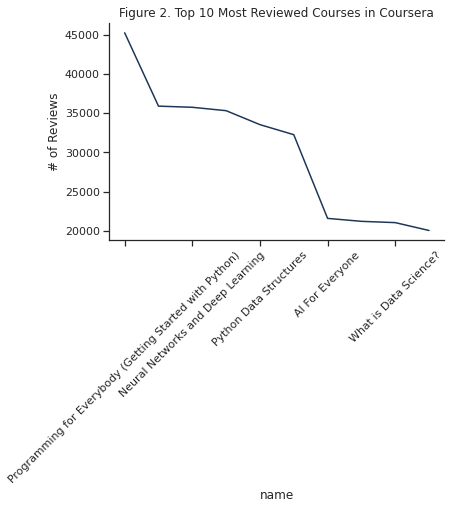

In [20]:
df_coursedb.groupby('name')['reviews'].count().sort_values(ascending=False)[:10].plot()
plt.xticks(rotation=45);
plt.ylabel('# of Reviews')
plt.title('Figure 2. Top 10 Most Reviewed Courses in Coursera')

df_coursedb.groupby('name')['reviews'].count().sort_values(ascending=False)[:10]

**Figure 2.** `Top 10 Most Reviewed Courses in Coursera` returned the list of courses with the most number of reviews from users. Scanning the list, we can deduce that majority of the reviewers actively reviewed or rated courses related to Data Science courses such as Python Programming, Machine Learning, Artificial Intelligence, Neural Networks and Deep Learning.

<h3 style="color:#0056D2">Top 10 Highly-rated Courses in Coursera</h3>

name
Entreprise et changement climatique                                                                5.000000
How to Manage a Remote Team                                                                        5.000000
Removing Barriers to Change                                                                        5.000000
Building Modern Python Applications on AWS                                                         5.000000
El Abogado del Futuro: Legaltech y la Transformación Digital del Derecho                           4.968000
Développement psychologique de l'enfant                                                            4.964706
The Horse Course: Introduction to Basic Care and Management                                        4.957364
Build a Modern Computer from First Principles: Nand to Tetris Part II (project-centered course)    4.956989
Bugs 101: Insect-Human Interactions                                                                4.955823
Economics of Money and 

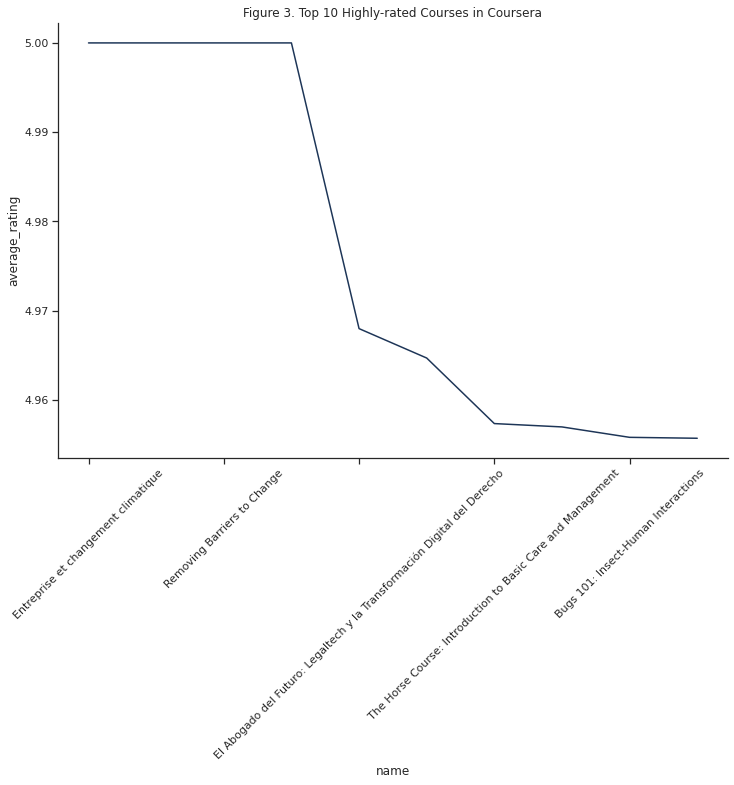

In [22]:
df_coursedb.groupby('name')['rating'].mean().sort_values(ascending=False)[:10].plot()
plt.xticks(rotation=45);
plt.ylabel('average_rating')
plt.title('Figure 3. Top 10 Highly-rated Courses in Coursera')

df_coursedb.groupby('name')['rating'].mean().sort_values(ascending=False)[:10]

**Figure 3.** `Top 10 Highly-rated Courses in Coursera` returned the list of courses with the highest average rating of courses offered in Coursera. Note that this list differs from the courses returned in the previous figure. We can deduce that even if courses were mostly reviewed, it does not follow that those courses listed in Figure 1 provides quality content. Given the popularity of the courses in Figure 2, we can provide this insight to the learning content provider so that they can improve and provide quality education. 

On the other hand, we can increase marketing to these courses returned in Figure 3 as these courses are the ones considered highly-rated from the diverse courses offered by the platform. Topics ranged from business and legal to horses and bugs.

<h3 style="color:#0056D2">Top 10 Institutions Offering Highly-rated Courses in Coursera</h3>

institution
GitLab                               5.000000
UCL School of Management             4.948276
Google - Spectrum Sharing            4.931034
Hebrew University of Jerusalem       4.928451
The University of Chicago            4.921771
Arizona State University             4.912794
University of Rochester              4.908163
Universidad de los Andes             4.906390
Universidade Estadual de Campinas    4.903674
Facebook                             4.886364
Name: rating, dtype: float64

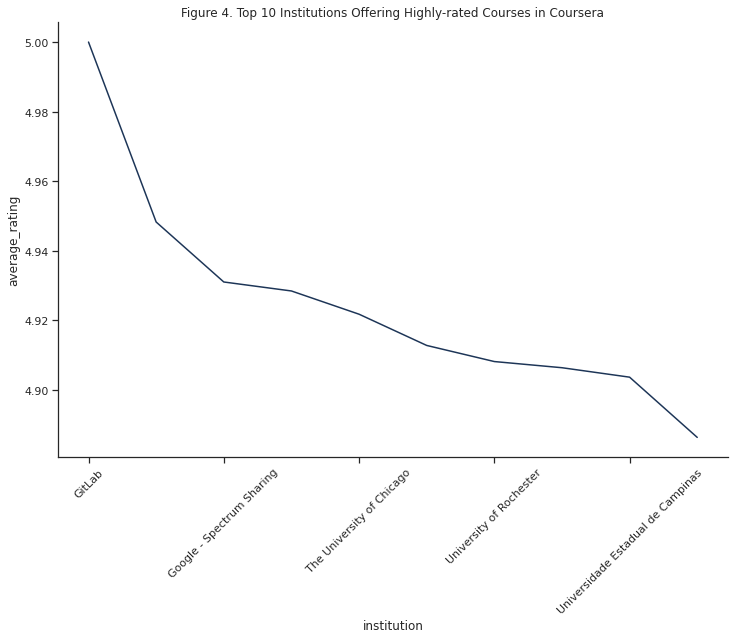

In [23]:
df_coursedb.groupby('institution')['rating'].mean().sort_values(ascending=False)[:10].plot()
plt.xticks(rotation=45);
plt.ylabel('average_rating')
plt.title('Figure 4. Top 10 Institutions Offering Highly-rated Courses in Coursera')

df_coursedb.groupby('institution')['rating'].mean().sort_values(ascending=False)[:10]

**Figure 4.** `Top 10 Institutions Offering Highly-rated Courses in Coursera` returned the list of institutions offering highly-rated courses (with highest average rating) of courses offered in Coursera. Gitlab topped the list as the only learning content provider with flat 5.0 average rating. GitLab is an open core company which develops software for the software development lifecycle used by more than 100,000 organizations, 30 million estimated registered users, and has an active community of more than 3000 contributors [3]. 

Apart from Gitlab and Google, note that the other non-conventional learning content provider would be Facebook or now known as Meta. The Meta Professional Certificates create opportunities so that anyone regardless of education, background or experience can learn high-quality skills to land a high-growth career—no degree or experience required to get started [4].

<h3 style="color:#0056D2">Top 10 Institutions with Most Reviewed Courses in Coursera</h3>

institution
University of Michigan                167057
DeepLearning.AI                       117015
Google                                 78602
IBM                                    70756
University of Pennsylvania             70521
Stanford University                    63504
University of California San Diego     59589
Johns Hopkins University               57134
Yale University                        51850
Google Cloud                           49270
Name: reviews, dtype: int64

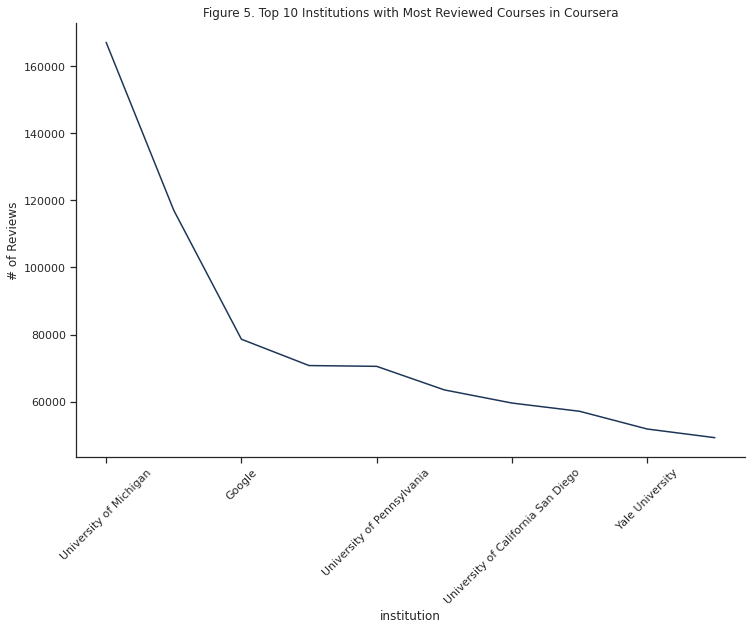

In [24]:
df_coursedb.groupby('institution')['reviews'].count().sort_values(ascending=False)[:10].plot()
plt.xticks(rotation=45);
plt.ylabel('# of Reviews')
plt.title('Figure 5. Top 10 Institutions with Most Reviewed Courses in Coursera')

df_coursedb.groupby('institution')['reviews'].count().sort_values(ascending=False)[:10]

**Figure 5.** `Top 10 Institutions with Most Reviewed Courses in Coursera` returned the list of institutions with the most number of reviews in the offered courses in the platform. Similar inference above, it does not follow that if the content provider is popular or garnered high number of reviews, it will receive highly-rated contents from users. 

<h3 style="color:#0056D2">Course Rating Distribution</h3>

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


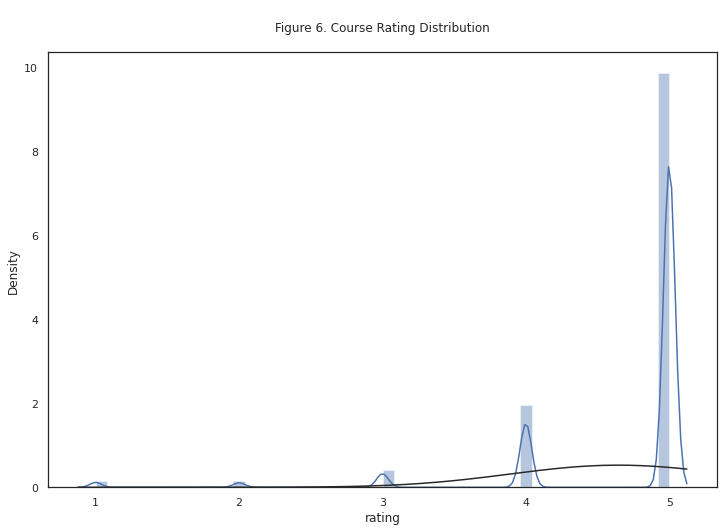

In [29]:
sns.set_style(style='white') 
p=sns.distplot(df_coursedb['rating'], fit=stats.gamma, label="label 1")
p.axes.set_title("\nFigure 6. Course Rating Distribution\n");

**Figure 6.** `Course Rating Distribution` - from the plot above, majority of the courses in the dataset are highly rated at 5. 

<h3 style="color:#0056D2">Sentiments from users who rated between 1 and 2</h3>

In [54]:
low_rating = df_coursedb[(df_coursedb.rating<=2) & (~df_coursedb.rating.isnull())]
low_rating.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,"Mar 18, 2017",1
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,"Nov 09, 2015",1
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,"Apr 15, 2019",1
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,"Sep 25, 2015",1
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,"Dec 12, 2015",1


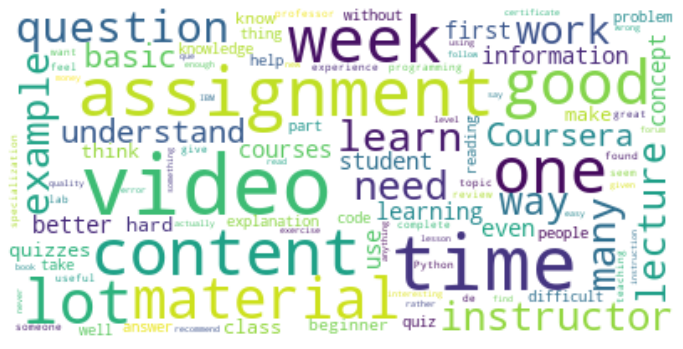

In [56]:
analyser = SentimentIntensityAnalyzer()
stop_words = (list(set(stopwords.words('english') + list(STOPWORDS))) +
                  ['course', 'really', 'much'])
wordcloud = WordCloud(max_font_size=50, max_words=100, 
                      background_color="white",
                      stopwords=stop_words).generate(' '.join(low_rating.sample(1000).reviews))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Figure 7.** `Sentiments from users who rated between 1 and 2`. From the plot above, it seems that virtual learners feedback about lot of assignments, questions the content/ material or instructor/ lecture. Comparing it to the next figure, the feedbacks from users who rated low have keywords that are related specific to the course. 

<h3 style="color:#0056D2">Sentiments from users who rated 3 and above</h3>

In [59]:
high_rating = df_coursedb[(df_coursedb.rating>2) & (~df_coursedb.rating.isnull())]
high_rating.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating
345,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"The course covers a lot of material, but in a ...",By Marcin K,"Mar 02, 2018",3
346,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,If this course was in python or R it would hav...,By Harshal M,"Mar 25, 2019",3
347,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,Excellent lessons by Prof. Andrew Ng.However v...,By Mirko J R,"Apr 02, 2019",3
348,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"This course was very difficult, coming from a ...",By トミー ペ,"Feb 03, 2019",3
349,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"Good introduction course, giving an overview o...",By Jerome P,"Mar 30, 2018",3


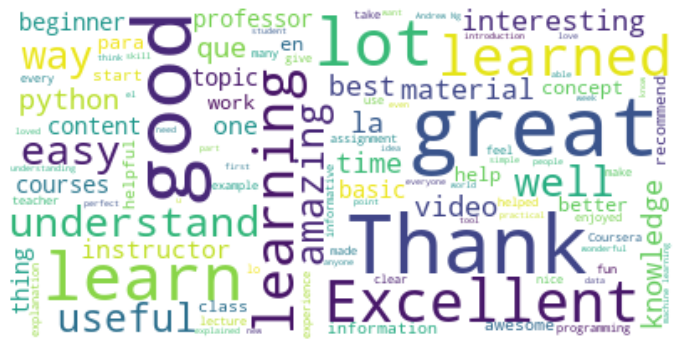

In [61]:
analyser = SentimentIntensityAnalyzer()
stop_words = (list(set(stopwords.words('english') + list(STOPWORDS))) +
                  ['course', 'really', 'much', 'de'])
wordcloud = WordCloud(max_font_size=50, max_words=100, 
                      background_color="white",
                      stopwords=stop_words).generate(' '.join(high_rating.sample(1000).reviews))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Figure 8.** `Sentiments from users who rated 3 and above`. Keywords returned in the plot above mainly refer to appreciation and gratitude towards the course, such as thankful, they learned a lot, interesting and easy to understand courses. 

<h3 style="color:#0056D2">Review Sentiments</h3>

**Valence Aware Dictionary for Sentiment Reasoning (VADER)** is an NLTK module that provides sentiment scores based on the words used. It is a rule-based sentiment analyzer in which the terms are generally labeled as per their semantic orientation as either positive or negative.

In [62]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [63]:
neg=[]
neu=[]
pos=[]
comp=[]
for review in df_coursedb.reviews:
    scores=sentiment_analyzer_scores(str(review))
    neg.append(scores['neg'])
    pos.append(scores['pos'])
    neu.append(scores['neu'])
    comp.append(scores['compound'])
    
df_coursedb['s_pos']=pos
df_coursedb['s_neu']=neu
df_coursedb['s_neg']=neg
df_coursedb['s_comp']=comp

In [81]:
for i in range(1000,1005):
    print ("----------------------------------------")
    print("Review : ",df_coursedb['reviews'][i])
    print("Positivity:",df_coursedb['s_pos'][i])
    print("Negativity:",df_coursedb['s_neg'][i])
    print ("----------------------------------------")

----------------------------------------
Review :  THIS IS A REVIEW FOR BEGINNERSADVANTAGES OF THE COURSEWhen I remember myself deciding whether or not I should take the course,  the questions that concerned me the most were these ones.    1.  Since I am a beginner in this field, will the course work for me?    2.  Did this course get outdated? (For those who don't know, the professor uses Octave)    3. In the end, will I feel like I can do some Machine Learning projects all by myself?For those who have the same questions, here are the answers for you )    1.  Yes, the course will work for you even if you are an absolute beginner like I was at the time (I did not know any linear algebra), It does get annoying sometimes and you feel a lot of pressure at some point of the course, but a hard-working person can surely get through it.  Mentors are active and very helpful if you get stuck on something.    2.  This question is a big NO for me, here is why:  When you are learning something fro

[ref]: #top
[Back to Table of Contents][ref]

<a name="results"></a>
***
<h1 style="color:#0056D2">RESULTS </h1>

***

<h2 style="color:#0056D2">Frequent Itemset Mining</h2>

From section 9.3.4 Top 10 Institutions with Most Reviewed Courses in Coursera above, we will be performing Frequent Itemset Mining (FIM) to determine the top content provider/ institutions offering courses.

Below code uses the CountVectorizer class from the scikit-learn library to create a matrix of itemset features, and then uses the cosine_similarity function from the same library to calculate the cosine similarities between all pairs of itemsets. The recommend_similar function takes an itemset index as input and returns the top N most similar itemsets based on cosine similarity. The code prints the top 5 most similar itemsets to the first itemset in the FIM result. You can change the input to the recommend_similar function to test the system with other itemsets.

In [84]:
fim_1st = df_coursedb[((df_coursedb.institution == 'University of Michigan') 
                           | (df_coursedb.institution == 'DeepLearning.AI'))]

fim_1st['name'] = fim_1st['name'].str.replace(' ',',')
fim_1st['name'] = fim_1st['name'].str.replace(',,',',')
fim_1st['name'] = fim_1st['name'].str.replace(':','')
fim_1st['name'] = fim_1st['name'].str.replace('(','')
fim_1st['name'] = fim_1st['name'].str.replace(')','')

fim_1st['reviews'] = fim_1st['reviews'].str.replace(' ',',')
fim_1st['reviews'] = fim_1st['reviews'].str.replace(',,',',')
fim_1st['reviews'] = fim_1st['reviews'].str.replace('_','')
fim_1st['reviews'] = fim_1st['reviews'].str.replace('.','')
fim_1st['reviews'] = fim_1st['reviews'].str.replace(':','')
fim_1st['reviews'] = fim_1st['reviews'].str.replace('(','')
fim_1st['reviews'] = fim_1st['reviews'].str.replace(')','')

fim_1st['course_id'] = fim_1st['course_id'].str.replace(' ',',')
fim_1st['course_id'] = fim_1st['course_id'].str.replace(',,',',')
fim_1st['course_id'] = fim_1st['course_id'].str.replace('_','')
fim_1st['course_id'] = fim_1st['course_id'].str.replace(':','')
fim_1st['course_id'] = fim_1st['course_id'].str.replace('(','')
fim_1st['course_id'] = fim_1st['course_id'].str.replace(')','')
fim_1st['course_id'] = fim_1st['course_id'].str.replace('-','')

fim_1st['reviews'] = fim_1st['reviews'].fillna("no review")

/tmp/ipykernel_138760/2725993994.py:7: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/tmp/ipykernel_138760/2725993994.py:8: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/tmp/ipykernel_138760/2725993994.py:13: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/tmp/ipykernel_138760/2725993994.py:15: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

/tmp/ipykernel_138760/2725

In [86]:
df = fim_1st[['name', 'course_id', 'reviews', 'reviewers']]
df['name'] = df['name'].str.replace(',',' ')
df['course_id'] = df['course_id'].str.replace(',',' ')
df['reviews'] = df['reviews'].str.replace(',',' ')

#lower casing the columns
df['name'] = df['name'].apply(lambda x:x.lower()) 
df['course_id'] = df['course_id'].apply(lambda x:x.lower())
df['reviews'] = df['reviews'].apply(lambda x:x.lower())
df['reviewers'] = df['reviewers'].apply(lambda x:x.lower())

df.head()

,name,course_id,reviews,reviewers
112432,programming for everybody getting started with...,python,i did not find this course helpful the assignm...,by eric v h
112433,programming for everybody getting started with...,python,i got a 95% and maybe i learned something but ...,by connor b
112434,programming for everybody getting started with...,python,two weeks of all sort of nonsense including ma...,by cyntia r t g
112435,programming for everybody getting started with...,python,we tried to use this class to teach a brown ba...,by steve m
112436,programming for everybody getting started with...,python,to be honest i thought the course stumbled and...,by terence p


In [87]:
freq_courses = df.groupby('reviewers').name.apply(set).tolist()

In [88]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import fim

itemsets = fim.fpgrowth(freq_courses, supp=1, zmin=2)
itemsets

[(('neural networks and deep learning',
   'programming for everybody getting started with python'),
  1433),
 (('python data structures',
   'programming for everybody getting started with python'),
  3088),
 (('python data structures',
   'neural networks and deep learning',
   'programming for everybody getting started with python'),
  713),
 (('python data structures', 'neural networks and deep learning'), 1257),
 (('improving deep neural networks hyperparameter tuning regularization and optimization',
   'programming for everybody getting started with python'),
  848),
 (('improving deep neural networks hyperparameter tuning regularization and optimization',
   'neural networks and deep learning'),
  2752),
 (('improving deep neural networks hyperparameter tuning regularization and optimization',
   'python data structures'),
  740),
 (('using python to access web data',
   'programming for everybody getting started with python'),
  1655),
 (('using python to access web data', 'ne

### Recommender System

In [89]:
itemsets_list = [itemset[0] for itemset in itemsets]
frequencies = [itemset[1] for itemset in itemsets]

# extract the itemsets and frequencies
itemsets_list = [itemset[0] for itemset in itemsets]
frequencies = [itemset[1] for itemset in itemsets]

# create a CountVectorizer object
vectorizer = CountVectorizer()

# fit and transform the itemsets to create a matrix of itemset features
itemsets_matrix = vectorizer.fit_transform([', '.join(itemset) for itemset in itemsets_list])

# calculate the cosine similarities between all itemset pairs
similarities = cosine_similarity(itemsets_matrix)

# define a function to recommend itemsets similar to a given itemset
def recommend_similar(itemset_index, top_n=5):
    # create a list of similarity scores between the given itemset and all others
    similarity_scores = list(enumerate(similarities[itemset_index]))
    # sort the similarity scores in descending order
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    # extract the indices of the top N most similar itemsets
    top_indices = [i[0] for i in similarity_scores[1:top_n+1]]
    # return the top N most similar itemsets
    return [itemsets_list[i] for i in top_indices]

# test the function on the first itemset
print(recommend_similar(0))

[('python data structures', 'neural networks and deep learning', 'programming for everybody getting started with python'), ('improving deep neural networks hyperparameter tuning regularization and optimization', 'programming for everybody getting started with python'), ('structuring machine learning projects', 'programming for everybody getting started with python'), ('using databases with python', 'programming for everybody getting started with python'), ('python data structures', 'programming for everybody getting started with python')]


### Sampling

In [91]:
df_coursedb_new = df_coursedb
df_coursedb_new['reviewers']=df_coursedb_new['reviewers'].str.replace('By ','')
df_coursedb_new

# Cluster Sampling
num_clusters = 5
cluster_var = 'institution'
grouped = df_coursedb_new.groupby(cluster_var)
clusters = np.random.choice(list(grouped.groups.keys()), size=num_clusters, replace=False)
df_clustered = pd.concat([grouped.get_group(cluster) for cluster in clusters])

In [92]:
df_clustered.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,s_pos,s_neu,s_neg,s_comp
1150719,Understanding International Relations Theory,National Research University Higher School of ...,https://www.coursera.org/learn/international-r...,international-relations-theory,This course is a SCAM. DO NOT PURCHASE! In the...,Gloria G d R,"Aug 18, 2019",1,0.035,0.734,0.231,-0.9452
1150720,Understanding International Relations Theory,National Research University Higher School of ...,https://www.coursera.org/learn/international-r...,international-relations-theory,The assigments are not allow to submit,Kavya A,"Jul 01, 2020",1,0.000,0.783,0.217,-0.1695
1150721,Understanding International Relations Theory,National Research University Higher School of ...,https://www.coursera.org/learn/international-r...,international-relations-theory,i do not understand this course,Chukwuazor e e,"Sep 29, 2020",1,0.000,1.000,0.000,0.0000
1150722,Understanding International Relations Theory,National Research University Higher School of ...,https://www.coursera.org/learn/international-r...,international-relations-theory,I cannot continue with the course because I co...,Sahrish R,"Oct 25, 2019",2,0.000,1.000,0.000,0.0000
1150723,Understanding International Relations Theory,National Research University Higher School of ...,https://www.coursera.org/learn/international-r...,international-relations-theory,I am giving this course 2 stars because I foun...,Miriam E,"Aug 03, 2020",2,0.073,0.829,0.098,-0.9611


In [38]:
df_users = df_clustered['reviewers'].value_counts().rename_axis('unique_users').reset_index(name='review_counts')
df_users

,unique_users,review_counts
0,Deleted A,52
1,Muhammad H,15
2,Mohamed A,12
3,Abhishek G,12
4,Eric H,12
...,...,...
5602,DANG N K,1
5603,S. M P R,1
5604,Cavid H,1
5605,Андрей,1


### Pick a name from the list below to use for the recommender system after.

In [39]:
df_users['unique_users'].tolist()

['Deleted A',
 'Muhammad H',
 'Mohamed A',
 'Abhishek G',
 'Eric H',
 'Amit K',
 'Saqib A',
 'Anant S',
 'Martin M',
 'Ahmed A',
 'Richard M',
 'Aditya K',
 'Hugo A',
 'Robert W',
 'Michael K',
 'HITESHKUMAR S',
 'Andrea M',
 'Erin M',
 'Dnyaneshwar M',
 'Koustav M',
 'Laura F',
 'M. A',
 'Thomas S',
 'Gaurav S P',
 'Sushant P',
 'Mahesh M',
 'Mohit M',
 'Dario S',
 'Quynh T P',
 'Maria P',
 'Vikas S',
 'BABLU A',
 'Jason M',
 'Nitin J',
 'david w',
 'Opas S',
 'Omar M S H',
 'Jessica C',
 'KUA M S',
 'Daniel M',
 'Md. R Q S',
 'Gary C',
 'Tushar B',
 'Alex C',
 'Jay C',
 'Ashraf A',
 'PAREKH P K',
 'Mukul S',
 'Hassam K',
 'Alexander S',
 'Juan J S',
 'Archisha B',
 'SREEHARAN B N',
 'Michal S',
 'Sivasundar K S',
 'Muhammad A',
 'Steve R',
 'Fuad H',
 'Sachin G',
 'Akshay G',
 'Jennifer F',
 'Giulia C',
 'Vivek P',
 'John S',
 'Rajesh S',
 'Andrea R',
 'Peter M',
 'أحمد م ف م س',
 'Md. A I',
 'Abhinav S',
 'Muhammad S',
 'Jason N',
 'NISHANT K',
 'Viet T',
 'SAURABH K',
 'VISHAL R L'

In [40]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_clustered[['reviewers', 'course_id', 'rating']], reader)

# SVD to reduce computational expense
algo = SVD()
trainset = data.build_full_trainset()
algo.fit(trainset)

def get_top_n(predictions, user, n=10):
    est_ratings = defaultdict(float)
    for uid, iid, true_r, est, _ in predictions:
        if uid == user_id:
            est_ratings[iid] = est
    top_n = [(iid, est_ratings[iid]) for iid in sorted(est_ratings, key=est_ratings.get, reverse=True)][:n]
    return top_n

# Get top-N recommendations for specific user
user_id = input("Enter username: ")
testset = trainset.build_anti_testset(fill=0)
predictions = algo.test(testset)
top_n = get_top_n(predictions, user_id, n=10)
print(f"Top recommendations for user {user_id}:")
for iid, rating in top_n:
    print(f"  - {iid}: {rating}")

Enter username: Siddharth S
Top recommendations for user Siddharth S:


### Evaluation

In [41]:
cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(f"Mean RMSE: {cv_results['test_rmse'].mean():.3f}")
print(f"Mean MAE: {cv_results['test_mae'].mean():.3f}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4028  0.3894  0.4613  0.4077  0.4032  0.4129  0.0250  
MAE (testset)     0.2567  0.2300  0.2613  0.2461  0.2445  0.2477  0.0109  
Fit time          0.67    0.70    0.73    0.70    0.67    0.69    0.02    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    
Mean RMSE: 0.413
Mean MAE: 0.248


[ref]: #top
[Back to Table of Contents][ref]

<a name="conclusion"></a>
***
<h1 style="color:#0056D2">CONCLUSION </h1>

***

Based on the analysis, it was found that the use of a content-based recommender system utilizing frequent itemsets can provide a viable alternative to collaborative filtering in recommending Coursera courses. This method was found to be computationally efficient and can provide personalized recommendations based on a user's past course preferences and relevant course attributes. Additionally, the use of pre-processing techniques such as text cleaning and feature engineering can improve the accuracy and relevance of the recommendations. Overall, this approach can be a valuable tool for both Coursera users looking for personalized course recommendations and Coursera itself in terms of improving user engagement and satisfaction.

Recommendations of similar courses to learners based on their preferences or enrolled courses is a practical approach for enhancing the profitability of course providers in the age of online learning.

<a name="recommendation"></a>
***
<h1 style="color:#0056D2">RECOMMENDATION </h1>

***

1. We can test out with other recommendation methods.
2. We can seek out waays to pull this recommendation system off without sampling.

<a name="references"></a>
***
<h1 style="color:#0056D2">REFERENCES </h1>

***

[1] Coursera, Inc. Form 10-K For The Year Ended December 31, 2022. https://www.sec.gov/ix?doc=/Archives/edgar/data/0001651562/000095017023004143/cour-20221231.htm.

[2] Coursera Prospectus dataed March 30, 2021. https://www.sec.gov/Archives/edgar/data/1651562/000119312521102478/d65490d424b4.htm#toc65490_7.

[3] GitLab. https://www.coursera.org/gitlab.

[4] Meta. https://www.coursera.org/meta.